In [1]:
# carregando sistema físico
from m3l.structure import System as sys
import json
#
system = sys()
system.loadSystem('system_new.json')
system.convertUnits()
system.save('system_au.json')
#system.convertUnitsInv()
#system.atoms
#system.cell

In [2]:
# definindo o modelo de interação entre os átomos (campo de força)
from m3l.molecular_dynamics import ForceField
class Forces(ForceField):
    def __init__(self):
        super().__init__()
        self.parameters((0.250/self.ECONV, 3.405/self.ACONV, 12.0/self.ACONV))

model = Forces()
model()

array([3.98576808e-04, 6.43451745e+00, 2.26767135e+01])

In [3]:
# definindo o modelo estatístico (ensemble)
from m3l.molecular_dynamics import Ensemble as en
#
temperature = 84.4
temperature = temperature/system.TEMPCONV
pressure = 1.0
timestep = 1.0e-8
timestep = timestep/system.TIMECONV
force_field = model()
tstat = 0.5/system.TIMECONV
ensemble = en(temperature, pressure, timestep, force_field, tstat = tstat)
ensemble(system)
#system.save('system_new.json')

In [4]:
# Definindo método de otimização
#from m3l.optimize import Optimize as optim
#
#opt = optim(model(), learning_rate = 1.e-2)

In [5]:
# executando looping
import time
import csv
#
n_steps = 10000
i_step = 0
start = time.time()
with open('history.csv', 'w', newline = '') as csvfile1, open('thermodynamics.csv', 'w', newline = '') as csvfile2:
    fieldnames1 = ['time', 'atom', 'x', 'y', 'z']
    writer1 = csv.DictWriter(csvfile1, fieldnames = fieldnames1)
    writer1.writeheader()
    fieldnames2 = ['time', 'temperature', 'epotential', 'ekinetic']
    writer2 = csv.DictWriter(csvfile2, fieldnames = fieldnames2)
    writer2.writeheader()
    for step in range(n_steps):
#        em = system.epotential
        system = ensemble(system)
#        en = system.epotential
#        if (en-em)*system.ECONV > 1.0e2:
#            for stp in range(20):
#                system = opt.SD(system)
        if step%100 == 0:
            i_step += 1
            writer2.writerow({
                'time': timestep*step*system.TIMECONV, 
                'temperature': system.temperature*system.TEMPCONV,
                'epotential': system.epotential*system.ECONV,
                'ekinetic': system.ekinetic*system.ECONV})
            for atom in system.atoms:
                writer1.writerow({
                    'time': timestep*step*system.TIMECONV,
                    'atom': atom[0],
                    'x': atom[1]*system.ACONV,
                    'y': atom[2]*system.ACONV,
                    'z': atom[3]*system.ACONV})
#            print(f'Step: {i_step}; Energy: {system.epotential*system.ECONV}')
#
end = time.time()
print(f'Elapsed time: {end - start}')
#

Elapsed time: 45.500723123550415


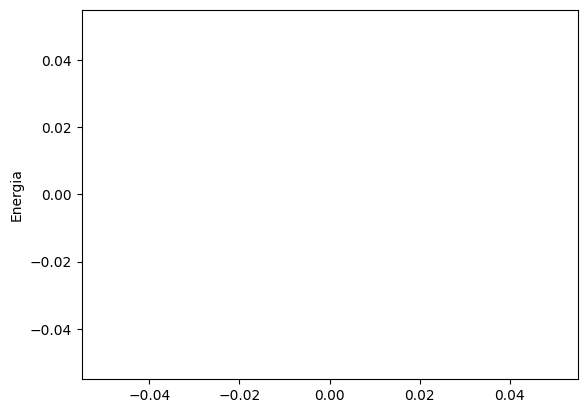

In [6]:
import matplotlib.pyplot as plt
import numpy as np
dataset = np.loadtxt("thermodynamics.csv", dtype=np.float32, delimiter = ",", skiprows=1)
x_list = [item[0].item() for item in dataset]
y_list = [(item[3].item()+item[2].item()) for item in dataset]
plt.plot(x_list, y_list)
plt.ylabel('Energia')
#plt.ylim(0,1e28)
plt.show()

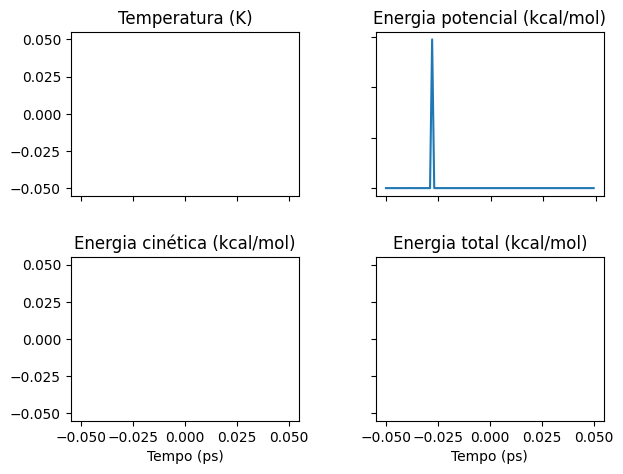

In [7]:
#temp_medio = sum(temp_list)/len(temp_list)
dataset = np.loadtxt("thermodynamics.csv", dtype=np.float32, delimiter = ",", skiprows=1)
time = [item[0].item() for item in dataset]
temp = [item[1].item() for item in dataset]
epot = [item[2].item() for item in dataset]
ekin = [item[3].item() for item in dataset] 
etotal = [(item[2].item()+item[3].item()) for item in dataset] 
#plt.plot(time, temp)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(time, temp)
axs[0, 0].set_title("Temperatura (K)")
axs[0, 1].plot(time, epot)
axs[0, 1].set_title("Energia potencial (kcal/mol)")
axs[1, 0].plot(time, ekin)
axs[1, 0].set_title("Energia cinética (kcal/mol)")
axs[1, 1].plot(time, etotal)
axs[1, 1].set_title("Energia total (kcal/mol)")
fig.tight_layout()
for ax in axs.flat:
    ax.set(xlabel='Tempo (ps)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig("MD.jpg")

In [8]:
system.convertUnitsInv()
#system.save('system_new.json')